In [1]:
# Imorting libraries
import pandas as pd
import numpy as np
import random
import statistics

In [3]:
# reading files
df_anime = pd.read_csv('anime.csv')
print(df_anime.shape)
df_anime.head()

(12294, 7)


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [4]:
df_rating = pd.read_csv('rating.csv')
print(df_rating.shape)
df_rating.head()

(7813737, 3)


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [5]:
# checking if there are any null values in both the dataframes
df_anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [6]:
df_rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [7]:
#checking unique anime and user IDs
len(df_rating['user_id'].unique())

73515

In [8]:
len(df_rating['anime_id'].unique())

11200

##### From the above files, we will only be using df_rating dataframe to build our models

# Performing EDA

In [9]:
# avg number of anime rated per user
ratings_per_user = df_rating.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())

106.28765558049378

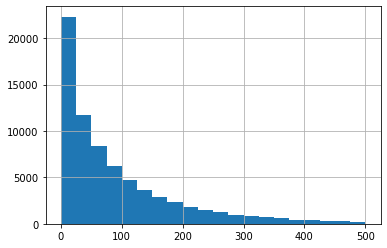

In [10]:
# distribution of ratings per user
import matplotlib.pyplot as plt
%matplotlib inline
ratings_per_user.hist(bins=20, range=(0,500))

#### From the above plot it is clear that most of the users have rated less than 500 anime

In [11]:
df_rating.groupby('user_id')['rating'].count().reset_index().sort_values('rating', ascending=False)[:15]

,user_id,rating
48764,48766,10227
42634,42635,3747
53696,53698,2905
57618,57620,2702
59641,59643,2633
51691,51693,2622
27363,27364,2499
45658,45659,2469
7344,7345,2429
66019,66021,2362


#### The above information shows that the most productive user have given 10227 ratings

In [12]:
# avg number of ratings given per anime
ratings_per_anime = df_rating.groupby('anime_id')['rating'].count()
statistics.mean(ratings_per_anime.tolist())

697.6550892857143

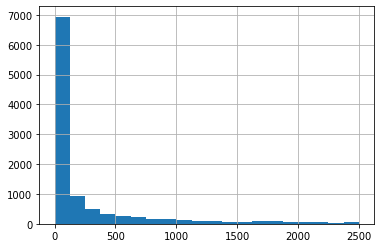

In [13]:
# distribution of ratings per anime
import matplotlib.pyplot as plt
%matplotlib inline
ratings_per_anime.hist(bins=20, range=(0,2500))

#### From the above plot it is clear that most of th anime have received less than 500 ratings

In [14]:
df_rating.groupby('anime_id')['rating'].count().reset_index().sort_values('rating',ascending=False)[:15]

,anime_id,rating
1389,1535,39340
6606,11757,30583
7439,16498,29584
1427,1575,27718
201,226,27506
4630,6547,27183
10,20,25925
99,121,25032
3965,5114,24574
3558,4224,24283


#### The above information shows that the most rated anime have got 39340 ratings

#### The above two plots shows the same distribution. Which means the number of ratings per user and number of ratings per anime reduces exponentially. 

In [15]:
# Avoiding memory error and reducing dimenionality of the data set. 
# randomly selecting only those users who has rated min 200 anime and anime that has recieved 250 ratings 

In [16]:
min_user_ratings = 200
filter_users = df_rating['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

min_anime_ratings = 250
filter_anime = df_rating['anime_id'].value_counts() > min_anime_ratings
filter_anime = filter_anime[filter_anime].index.tolist()

random.seed(9999)
df_new = df_rating[(df_rating['user_id'].isin(filter_users)) & 
                   (df_rating['anime_id'].isin(filter_anime))].sample(frac=.3)
print('The original data frame shape:\t{}'.format(df_rating.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(7813737, 3)
The new data frame shape:	(1171843, 3)


In [17]:
len(df_new['user_id'].unique())  #checking unique anime ids

11193

In [18]:
len(df_new['anime_id'].unique())  #checking unique anime ids

3318

In [19]:
#checking number of -1 rating 
df_neg = df_new[df_new.rating == -1]
df_neg.shape

(226049, 3)

In [20]:
#checking number of anime that have got rating from user
df_pos = df_new[df_new.rating != -1]
df_pos.shape

(945794, 3)

## Collaborative filtering using surprise package

In [21]:
from surprise import Reader, Dataset,accuracy

In [22]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_new[['user_id', 'anime_id', 'rating']], reader)

In [23]:
random.seed(9999)
#spliting the data into train and test data set
from surprise.model_selection import train_test_split
train_n, test_n = train_test_split(data, test_size= .35)

In [24]:
#checking the type of train and test data
print('Type trainset :',type(train_n),'\n')
print('Type testset :',type(test_n))

Type trainset : <class 'surprise.trainset.Trainset'> 

Type testset : <class 'list'>


In [25]:
#exploring test data set
print(len(test_n))
print(test_n[0])

410146
(27500, 15687, 10.0)


In [26]:
#importing from surprise package
from surprise.prediction_algorithms import knns
from surprise.similarities import cosine,pearson
from surprise import accuracy

In [27]:
#checking number of user and anime in train data
print('Number of users: ', train_n.n_users, '\n')
print('Number of anime: ', train_n.n_items, '\n')



Number of users:  11193 

Number of anime:  3318 



In [28]:
#function to get top n predictions
from collections import defaultdict
def get_top_n(predictions, n=10):
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, r_ui, est, _ in predictions:
        top_n[uid].append((iid, est, r_ui))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        # print(user_ratings)
        user_ratings = sorted(user_ratings,key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

## Performing Item-item based collaborative filtering using surprise 

##### We will be using KNN, KNN with means and KNNBaselines method to build models 
##### Similarity measures used Cosine and Pearson
##### Evaluation metric used RMSE

### A: Build models using cosine similarity

In [29]:
# defining similarity metrics
sim_cos = {'name':'cosine', 'user_based':False}

###### Fitting model with KNN method

In [30]:
# fiting the KNN model on train data 
Kbasic = knns.KNNBasic(sim_options=sim_cos)
Kbasic.fit(train_n)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [31]:
# testing the above fitted model on test data set
predictions = Kbasic.test(test_n)

In [32]:
# evaluating using rmse
acc = accuracy.rmse(predictions)
print("KNN accuracy with cosine similarity", acc)

RMSE: 2.2147
KNN accuracy with cosine similarity 2.2147100725603126


In [33]:
# geting top n predictions
top_pred_knn = get_top_n(predictions,20)

In [35]:
top_pred_knn[50877]

[(27655, 7.863911412295212, 7.0),
 (9041, 7.768290904891257, 8.0),
 (26441, 7.767669661128019, 8.0),
 (10793, 7.755072120223349, 7.0),
 (11757, 7.726964960251679, 10.0),
 (121, 7.724683435410317, 10.0),
 (28907, 7.677954570814168, 8.0),
 (2404, 7.591305592909373, 8.0),
 (23321, 7.56047311650403, -1.0),
 (16011, 7.5487770454005645, 8.0),
 (1606, 7.5341702939024895, -1.0),
 (4063, 7.521807125537278, 8.0),
 (226, 7.5014717605881795, 10.0),
 (986, 7.474246432845613, 9.0),
 (31240, 7.464378488022569, 9.0),
 (1164, 7.440617172546458, 8.0),
 (2993, 7.397581187045008, 7.0),
 (5958, 7.392443700163795, 7.0),
 (228, 7.358151912255911, 8.0),
 (29803, 7.355342497104647, 9.0)]

##### Fitting model with KNNWithMeans method

In [36]:
# fiting the KNN with means model on train data 
KMeans = knns.KNNWithMeans(sim_options=sim_cos)
KMeans.fit(train_n)


Computing the cosine similarity matrix...
Done computing similarity matrix.


In [37]:
# testing the above fitted model on test data set
predictions_m = KMeans.test(test_n)

In [38]:
# evaluating using rmse
acc_m = accuracy.rmse(predictions_m)
print("KNNWithMeans accuracy with cosine similarity", acc_m)

RMSE: 2.1263
KNNWithMeans accuracy with cosine similarity 2.1262819936476403


In [39]:
#getting top n predictions
top_pred_knn_m = get_top_n(predictions_m,20)

In [40]:
top_pred_knn_m[50877]

[(31240, 8.171627671918259, 9.0),
 (1689, 8.147364663101508, 8.0),
 (22297, 8.122722608767448, 8.0),
 (11757, 8.117627484520641, 10.0),
 (121, 8.025136394954787, 10.0),
 (10793, 7.865133044317727, 7.0),
 (28907, 7.827378270863756, 8.0),
 (226, 7.734880376826577, 10.0),
 (29803, 7.687860980294356, 9.0),
 (31637, 7.575222075664661, 8.0),
 (27655, 7.561638313635886, 7.0),
 (1606, 7.512231146605437, -1.0),
 (16011, 7.461741999705486, 8.0),
 (16009, 7.412920866437821, 7.0),
 (12467, 7.409458434879552, 7.0),
 (9332, 7.409353681290079, 6.0),
 (228, 7.268375541262626, 8.0),
 (5958, 7.242462341129809, 7.0),
 (23321, 7.2399912257975405, -1.0),
 (9041, 7.182832664723447, 8.0)]

##### Fitting model with KNNBaseline method

In [41]:
# fiting the KNNBaseline model on train data 
KBase = knns.KNNBaseline(sim_options=sim_cos)
KBase.fit(train_n)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [42]:
# testing the above fitted model on test data set
predictions_b = KBase.test(test_n)

In [43]:
# evaluating using rmse
acc_b = accuracy.rmse(predictions_b)
print("KNNBaseline accuracy with cosine similarity", acc_b)

RMSE: 2.1163
KNNBaseline accuracy with cosine similarity 2.1162847402898137


In [44]:
#getting top n predictions
top_pred_knn_b = get_top_n(predictions_b,20)

In [45]:
top_pred_knn_b[50877]

[(121, 8.075666161884456, 10.0),
 (31240, 8.033532482449202, 9.0),
 (11757, 8.000867522235328, 10.0),
 (22297, 7.937477695990111, 8.0),
 (1689, 7.901106694601762, 8.0),
 (10793, 7.7699457079610035, 7.0),
 (28907, 7.744071107802116, 8.0),
 (226, 7.689380937154447, 10.0),
 (27655, 7.507674834804395, 7.0),
 (16011, 7.497838641003867, 8.0),
 (29803, 7.495696053079993, 9.0),
 (1606, 7.478771288387837, -1.0),
 (23321, 7.398243574990202, -1.0),
 (16009, 7.369354062186998, 7.0),
 (228, 7.347018995694419, 8.0),
 (31637, 7.3293173437202, 8.0),
 (9332, 7.283086292689589, 6.0),
 (5958, 7.241789035459241, 7.0),
 (26441, 7.176979005096149, 8.0),
 (9041, 7.172110087196468, 8.0)]

### B: Build models using pearson similarity

In [46]:
# defining similarity metrics
sim_pear = {'name':'pearson', 'user_based':False}

##### Fitting model with KNN method

In [47]:
# fiting the KNN model on train data 
K_basic = knns.KNNBasic(sim_options=sim_pear)
K_basic.fit(train_n)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [48]:
# testing the above fitted model on test data set
predictions_p = K_basic.test(test_n)

In [49]:
# evaluating using rmse
acc_p = accuracy.rmse(predictions_p)
print("KNN accuracy with pearson similarity", acc_p)

RMSE: 2.2104
KNN accuracy with pearson similarity 2.2103852846685035


In [50]:
# geting top n predictions
top_pred_knn_p = get_top_n(predictions_p,20)

In [51]:
top_pred_knn_p[50877]

[(1606, 7.7162989593322004, -1.0),
 (2404, 7.70735341672896, 8.0),
 (12467, 7.689210681461972, 7.0),
 (1336, 7.684331912751296, 7.0),
 (9041, 7.638346730564549, 8.0),
 (27655, 7.60126508234109, 7.0),
 (28907, 7.5753569968599805, 8.0),
 (23321, 7.565336802211799, -1.0),
 (9332, 7.55748986899728, 6.0),
 (121, 7.540965565980139, 10.0),
 (26441, 7.530007365165607, 8.0),
 (22297, 7.517837090405148, 8.0),
 (29803, 7.500700817681466, 9.0),
 (986, 7.458874841114573, 9.0),
 (16011, 7.405107772234404, 8.0),
 (228, 7.3960834278843945, 8.0),
 (1164, 7.38002427394561, 8.0),
 (31240, 7.350544426017543, 9.0),
 (10793, 7.347768030943014, 7.0),
 (343, 7.339853217253912, 8.0)]

###### Fitting model with KNNWithMeans method

In [52]:
# fiting the KNNWithMeans model on train data 
K_Means = knns.KNNWithMeans(sim_options=sim_pear)
K_Means.fit(train_n)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [54]:
# testing the above fitted model on test data set
predictions_x = K_Means.test(test_n)

In [56]:
# evaluating using rmse
acc_x = accuracy.rmse(predictions_x)
print("KNNWithMeans accuracy with pearson similarity", acc_x)

RMSE: 2.1151
KNNWithMeans accuracy with pearson similarity 2.1151022145427585


In [57]:
# getting top n predictions
top_pred_knn_x = get_top_n(predictions_x,20)

In [58]:
top_pred_knn_x[50877]

[(22297, 8.418069455463996, 8.0),
 (31240, 8.206598105040696, 9.0),
 (1689, 8.150332061104368, 8.0),
 (121, 7.977852560018846, 10.0),
 (29803, 7.95075470295039, 9.0),
 (12467, 7.8673897201184495, 7.0),
 (28907, 7.796964929125836, 8.0),
 (1606, 7.654534728741059, -1.0),
 (9332, 7.626053744109188, 6.0),
 (226, 7.606546460156811, 10.0),
 (31637, 7.597032277488651, 8.0),
 (11757, 7.587415987088978, 10.0),
 (10793, 7.5591353188711805, 7.0),
 (27655, 7.396183580539111, 7.0),
 (228, 7.354366704669385, 8.0),
 (23321, 7.349515654874535, -1.0),
 (16009, 7.2820967906815035, 7.0),
 (16011, 7.26082288067894, 8.0),
 (2993, 7.221104863979203, 7.0),
 (9041, 7.080713313706259, 8.0)]

##### Fitting model with KNNBaseline method

In [59]:
# fiting the KNNBaseline model on train data 
K_Base = knns.KNNBaseline(sim_options=sim_pear)
K_Base.fit(train_n)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [60]:
# testing the above fitted model on test data set
predictions_r = K_Base.test(test_n)

In [61]:
# evaluating using rmse
acc_r = accuracy.rmse(predictions_r)
print("KNNBaseline accuracy with pearson similarity", acc_r)

RMSE: 2.1054
KNNBaseline accuracy with pearson similarity 2.105387165802676


In [62]:
# getting top n predictions
top_pred_knn_r = get_top_n(predictions_r,20)
top_pred_knn_r[50877]

[(22297, 8.234753374041171, 8.0),
 (31240, 8.059812303686103, 9.0),
 (121, 7.998516152796367, 10.0),
 (1689, 7.884401628301972, 8.0),
 (28907, 7.732008319832296, 8.0),
 (29803, 7.713949818879352, 9.0),
 (1606, 7.633841420016772, -1.0),
 (12467, 7.590111075026991, 7.0),
 (226, 7.5209782125400615, 10.0),
 (9332, 7.515026386533637, 6.0),
 (23321, 7.492618754705244, -1.0),
 (10793, 7.468175650322573, 7.0),
 (11757, 7.4569037462804815, 10.0),
 (228, 7.421459371106026, 8.0),
 (31637, 7.37766365193989, 8.0),
 (27655, 7.337109850736618, 7.0),
 (16011, 7.3260643282536355, 8.0),
 (16009, 7.262323743261044, 7.0),
 (208, 7.086917531796121, 10.0),
 (9041, 7.075496451572246, 8.0)]

## Performing User-User based collaborative filtering using surprise 

##### We will be using KNN, KNN with means and KNNBaselines method to build models 
##### Similarity measures used Cosine and Pearson
##### Evaluation metric used RMSE

### A: Build models using cosine similarity

In [63]:
# defining similarity metrics
sim_ucos = {'name':'cosine', 'user_based':True}

##### Fitting model with KNN method

In [64]:
# fiting the KNN model on train data 
Kbasic_u = knns.KNNBasic(sim_options=sim_ucos)
Kbasic_u.fit(train_n)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [65]:
# testing the above fitted model on test data set
predictions_u = Kbasic_u.test(test_n)

In [66]:
# evaluating using rmse
acc_u = accuracy.rmse(predictions_u)
print("KNN accuracy with cosine similarity", acc_u)

RMSE: 2.4697
KNN accuracy with cosine similarity 2.469718380053919


In [67]:
# getting top n predictions
top_pred_knn_u = get_top_n(predictions_u,20)
top_pred_knn_u[50877]

[(31240, 8.375, 9.0),
 (22297, 8.3, 8.0),
 (11757, 8.275, 10.0),
 (208, 7.925104121454358, 10.0),
 (31637, 7.85, 8.0),
 (226, 7.85, 10.0),
 (28907, 7.725, 8.0),
 (1689, 7.725, 8.0),
 (121, 7.675, 10.0),
 (10793, 7.6, 7.0),
 (1606, 7.449848873965831, -1.0),
 (9332, 7.448102485808395, 6.0),
 (9041, 7.425, 8.0),
 (29803, 7.4, 9.0),
 (16009, 7.4, 7.0),
 (23321, 7.325, -1.0),
 (343, 7.299647518933949, 8.0),
 (5958, 7.25, 7.0),
 (12467, 7.249882064083561, 7.0),
 (2993, 7.15, 7.0)]

##### Fitting model with KNNWithMeans method

In [68]:
# fiting the KNNWithMeans model on train data 
KMeans_e = knns.KNNWithMeans(sim_options=sim_ucos)
KMeans_e.fit(train_n)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [69]:
# testing the above fitted model on test data set
predictions_e = KMeans_e.test(test_n)

In [70]:
# evaluating using rmse
acc_e = accuracy.rmse(predictions_e)
print("KNNWithMeans accuracy with cosine similarity", acc_e)

RMSE: 2.1351
KNNWithMeans accuracy with cosine similarity 2.1350790668900084


In [71]:
# getting top n predictions
top_pred_knn_e = get_top_n(predictions_e,20)
top_pred_knn_e[50877]

[(11757, 8.724613548221138, 10.0),
 (31240, 8.46155548330291, 9.0),
 (22297, 8.390298833879136, 8.0),
 (1689, 8.219878052170976, 8.0),
 (208, 7.9201373344265305, 10.0),
 (16009, 7.803724607363831, 7.0),
 (226, 7.748464759739755, 10.0),
 (28907, 7.735095213281667, 8.0),
 (121, 7.70667127183274, 10.0),
 (228, 7.687307897395663, 8.0),
 (31637, 7.579012376579536, 8.0),
 (4063, 7.578645822370639, 8.0),
 (1606, 7.574823922649921, -1.0),
 (10793, 7.566385984493934, 7.0),
 (5958, 7.492356656901735, 7.0),
 (29803, 7.425592360407722, 9.0),
 (16011, 7.379463659530572, 8.0),
 (9332, 7.311473960332954, 6.0),
 (23321, 7.230454803754627, -1.0),
 (300, 7.217606566581924, 6.0)]

##### Fitting model with KNNBaseline method

In [72]:
# fiting the KNNBaseline model on train data 
KBase_f = knns.KNNBaseline(sim_options=sim_ucos)
KBase_f.fit(train_n)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [73]:
# testing the above fitted model on test data set
predictions_f = KBase_f.test(test_n)

In [74]:
# evaluating using rmse
acc_f = accuracy.rmse(predictions_f)
print("KNNBaseline accuracy with cosine similarity", acc_f)

RMSE: 2.1339
KNNBaseline accuracy with cosine similarity 2.1339338337359117


In [75]:
# getting top n predictions
top_pred_knn_f = get_top_n(predictions_f,20)
top_pred_knn_f[50877]

[(11757, 8.548376175963256, 10.0),
 (31240, 8.47583014325972, 9.0),
 (22297, 8.316085333074673, 8.0),
 (1689, 8.054150606598052, 8.0),
 (208, 7.833142020062522, 10.0),
 (226, 7.718044030861152, 10.0),
 (28907, 7.714422990799071, 8.0),
 (121, 7.638949456662434, 10.0),
 (16009, 7.615037926800309, 7.0),
 (31637, 7.561811130803961, 8.0),
 (10793, 7.515580355952969, 7.0),
 (228, 7.476287917814783, 8.0),
 (1606, 7.4444206901595065, -1.0),
 (29803, 7.341146656936939, 9.0),
 (5958, 7.3397057079301415, 7.0),
 (4063, 7.327506523151727, 8.0),
 (16011, 7.20302862756931, 8.0),
 (9332, 7.177589704442449, 6.0),
 (23321, 7.163556575353715, -1.0),
 (27655, 7.00887523750949, 7.0)]

### B: Build models using pearson similarity

In [76]:
# defining similarity metrics
sim_upear = {'name':'pearson', 'user_based':True}

##### Fitting model with KNN method

In [77]:
# fiting the KNN model on train data 
Kbasic_h = knns.KNNBasic(sim_options=sim_upear)
Kbasic_h.fit(train_n)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [78]:
# testing the above fitted model on test data set
predictions_h = Kbasic_h.test(test_n)

In [79]:
# evaluating using rmse
acc_h = accuracy.rmse(predictions_h)
print("KNN accuracy with pearson similarity", acc_h)

RMSE: 3.5966
KNN accuracy with pearson similarity 3.5966258131881146


In [80]:
# getting top n predictions
top_pred_knn_h = get_top_n(predictions_h,20)
top_pred_knn_h[50877]

[(22297, 7.975, 8.0),
 (11757, 7.75, 10.0),
 (31240, 7.7, 9.0),
 (121, 7.65, 10.0),
 (29803, 7.525, 9.0),
 (2404, 7.51036848471493, 8.0),
 (1606, 7.487447099311446, -1.0),
 (226, 7.425, 10.0),
 (1689, 7.4, 8.0),
 (4063, 7.3, 8.0),
 (31637, 7.275, 8.0),
 (10793, 7.275, 7.0),
 (23321, 7.175082947197121, -1.0),
 (228, 7.04578721401207, 8.0),
 (26441, 6.97241078431642, 8.0),
 (208, 6.96163421422999, 10.0),
 (2993, 6.95, 7.0),
 (5958, 6.9, 7.0),
 (9041, 6.875, 8.0),
 (343, 6.810306105822151, 8.0)]

##### Fitting model with KNNWithMeans method

In [81]:
# fiting the KNNWithMeans model on train data 
KMeans_w = knns.KNNWithMeans(sim_options=sim_upear)
KMeans_w.fit(train_n)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [82]:
# testing the above fitted model on test data set
predictions_w = KMeans_w.test(test_n)

In [83]:
# evaluating using rmse
acc_w = accuracy.rmse(predictions_w)
print("KNNWithMeans accuracy with pearson similarity", acc_w)

RMSE: 2.1312
KNNWithMeans accuracy with pearson similarity 2.1311507208893445


In [84]:
# getting top n predictions
top_pred_knn_w = get_top_n(predictions_w,20)
top_pred_knn_w[50877]

[(1689, 8.185955655914997, 8.0),
 (11757, 8.133793956564796, 10.0),
 (22297, 8.129111100780923, 8.0),
 (29803, 8.09683673228961, 9.0),
 (226, 7.932489386205672, 10.0),
 (121, 7.899616069863907, 10.0),
 (31637, 7.848505622301062, 8.0),
 (31240, 7.777702863820456, 9.0),
 (12467, 7.6240801547629, 7.0),
 (208, 7.573456439868159, 10.0),
 (1606, 7.556275003576253, -1.0),
 (4063, 7.530312923809874, 8.0),
 (2404, 7.478362728406149, 8.0),
 (10793, 7.426424767748934, 7.0),
 (228, 7.425686665925512, 8.0),
 (23321, 7.372967932534988, -1.0),
 (16011, 7.357029596016721, 8.0),
 (26441, 7.332239135842783, 8.0),
 (2993, 7.226297796184229, 7.0),
 (9041, 7.200534816563825, 8.0)]

##### Fitting model with KNNBaseline method

In [85]:
# fiting the KNNBaseline model on train data 
KBase_g = knns.KNNBaseline(sim_options=sim_upear)
KBase_g.fit(train_n)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [86]:
# testing the above fitted model on test data set
predictions_g = KBase_g.test(test_n)

In [87]:
# evaluating using rmse
acc_g = accuracy.rmse(predictions_g)
print("KNNBaseline accuracy with pearson similarity", acc_g)

RMSE: 2.1841
KNNBaseline accuracy with pearson similarity 2.184094609838723


In [88]:
# getting top n predictions
top_pred_knn_g = get_top_n(predictions_g,20)
top_pred_knn_g[50877]

[(22297, 8.038022333792064, 8.0),
 (11757, 7.988013013572221, 10.0),
 (1689, 7.984255245590775, 8.0),
 (29803, 7.944777423772969, 9.0),
 (121, 7.782817558427122, 10.0),
 (226, 7.776882264809551, 10.0),
 (31240, 7.744767491035818, 9.0),
 (31637, 7.698171699381683, 8.0),
 (1606, 7.391887034341589, -1.0),
 (10793, 7.351891480175933, 7.0),
 (4063, 7.339520003284427, 8.0),
 (2404, 7.334456443796467, 8.0),
 (208, 7.316272351293869, 10.0),
 (228, 7.299050576091365, 8.0),
 (12467, 7.292473129664023, 7.0),
 (23321, 7.189063274521082, -1.0),
 (26441, 7.15345045978229, 8.0),
 (16011, 7.0864580231448135, 8.0),
 (2993, 7.006731060975384, 7.0),
 (5958, 6.96823958324141, 7.0)]

#### Conclusion: From the all the above twelve models,Item-based collaborative filtering performs well with pearson correlation as similarity metrics and RMSE value as 2.105. For item based the best KNN method was KNNBaseline. 